In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy 
from IPython.html.widgets import interact
from IPython.html.widgets import IntSlider

%matplotlib inline

from pylab import rcParams

In [68]:
class checkers_state:
    def __init__(self,board_size = 8, verbose = False, notes = None, allow_kings = True, allow_draws = False, max_turns = 100):        
        self.board_size = board_size
        self.board = self.create_board(n = board_size)
        self.player = 0
        #self.action_space = self.get_action_space()
        self.done = False
        self.num_just_jumped = 0
        self.update_action_space()
        self.verbose = verbose
        self.notes = None
        self.max_turns = max_turns
        self.turn_num = 0 ##Total number of turns moved thus far
        self.allow_draws = allow_draws
        
    def create_board(self, n):
        board = np.zeros([n,n]).astype(int)
        for i in range(n):
            for j in range(n):
                if i < n/2 - 1:
                    x = 1
                elif (n-i) < n/2:
                    x = -1
                else:
                    continue
                if (i + j) % 2 == 1:
                    board[j,i] = x
        return board    
    
    
    def show_board(self):
        #plt.clf()
        rcParams['figure.figsize'] = 4,4
        #fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
        # (or if you have an existing figure)
        # fig = plt.gcf()
        # ax = fig.gca()

        #ax.add_artist(circle2)
        fig, ax = plt.subplots() 

        #ax.add_artist(plt.Circle( (i + .5, j + .5), 0.2, color='blue'))

        for i in range(self.board_size):
            for j in range(self.board_size):
                if (i + j) % 2 == 0:
                    square_color = 'grey'
                else:
                    square_color = 'white'

                ax.add_artist(plt.Rectangle( (i, j), 1,1, color=square_color))
                if self.board[i,j] > 0:
                    color = 'red'
                elif self.board[i,j] < 0:
                    color = 'black'
                else:
                    continue
                #print i,j
                ax.add_artist(plt.Circle( (i + .5, j + .5), 0.2, color=color))
                if abs(self.board[i,j]) > 1:
                    ###This piece is a king
                    ax.add_artist(plt.Circle( (i + .5, j + .5), 0.3, color=color, fill = False))

        plt.xlim(0,self.board_size)
        plt.ylim(0,self.board_size)

        plt.show()
        
        
    
        
        
    def player_pieces(self, player = None):
        if player is None:
            player = self.player
        pieces = []
        for i in range(self.board_size):
            for j in range(self.board_size):
                if player == 0 and self.board[i,j] > 0:
                    pieces.append((i,j))
                if player == 1 and self.board[i,j] < 0:
                    pieces.append((i,j))
        return pieces
                
            
    def get_action_space(self):
        return self.action_space
    
    def update_action_space(self):
        possible_jumps = []
        possible_moves = []
        
        if self.num_just_jumped > 0:
            pieces_to_move = [self.last_jumper]
        else:
            pieces_to_move = self.player_pieces()
        
        for u in pieces_to_move:
            for move_vector in self.legal_vectors(u):
                v = (u[0] + move_vector[0], u[1] + move_vector[1])
                action = (u,v)
                if self.is_legal(action):
                    possible_moves.append(action)
                    if np.abs(move_vector[0]) > 1:
                        possible_jumps.append(action)
        
        if len(possible_jumps) > 0:
            #if you can jump, you must jump
            self.must_jump = True
            if self.verbose:
                print "MUST JUMP!!, possible jumps:", possible_jumps
            self.action_space = possible_jumps
        else:
            self.must_jump = False
            self.action_space =  possible_moves

    
    
    def get_action_from_int(self, i):
        if i > self.num_actions():
            raise ValueError("Action index %d not in range of action space of length %d" % (i, self.num_actions()))
        else:
            return self.action_space[i]
            
            
    def is_legal(self, action, explain = False):
        legal = True
        (u,v) = action
        #print 'Checking action', action
        if not all([0 <= u[i] < self.board_size for i in range(2)]):
            if explain:
                print "Player %d trying to move a piece not in range (0, %d)" % (self.player, self.board_size) 
            return False
        elif not all([0 <= v[i] < self.board_size for i in range(2)]):
            if explain:
                print "Player %d trying to move a piece to outside of (0, %d)" % (self.player, self.board_size) 
            return False
        
        if self.board[u] == 0:
            if explain:
                print "Player %d is trying to move from empty position (%d,%d)" % (self.player, u[0], u[1])

            return False
        elif self.board[v] != 0:
            if explain:
                print "Player %d is trying to move to nonempty position (%d,%d)" % (self.player, v[0], v[1])

            return False
        elif (self.board[u] > 0 and self.player == 1) or (self.board[u] > 0 and self.player == 1):
            if explain:
                print "Player %d trying to move a piece belonging to player %d" % (self.player, 1 - self.player)

            return False
        

            
        move_vector =  (v[0] - u[0], v[1] - u[1])   
        
        if not move_vector in self.legal_vectors(u):
            if explain:
                print "Player %d trying vector %s, not in legal vectors %s" % (self.player, move_vector, self.legal_vectors(u))

            return False
        
        
        if np.abs(move_vector[0]) > 1:
            
            w = (int((u[0] + v[0]) / 2), int((u[1] + v[1]) / 2))
            
            if self.player == 0 and self.board[w] < 0:
                pass
                #print "Jumped piece at position (%d,%d)" % w
            elif self.player == 1 and self.board[w] > 0:
                pass
                #print "Jumped piece at position (%d,%d)" % w
            else:
                if explain:
                    print "Player %d trying to jump own piece or empty position at %s" (self.player, w)
                return False        
        return True
        
        
    def legal_vectors(self, piece):
        if np.abs(self.board[piece]) > 1:
            #this piece is a king
            legal_vectors = [(1,1), (-1,1), (2,2), (-2, 2), (1,-1), (-1,-1), (2,-2), (-2, -2)]
        elif self.player == 0:
            legal_vectors =  [(1,1), (-1,1), (2,2), (-2, 2)]
        elif self.player == 1:
            legal_vectors = [(1,-1), (-1,-1), (2,-2), (-2, -2)]
            
        return legal_vectors
    
    def take_action(self, action, inplace = True):
        
        # an action is a tuple of two (u,v) where u,v are 2x2 vectors;
        # u coordinates of a checker, v coordinates of a place to move to
        
        (u,v) = action
        
        #player = 0 -> positive pieces
        #player = 1 -> negative pieces
        
        if not all([0 <= u[i] < self.board_size for i in range(2)]):
            raise ValueError("Player %d trying to move a piece not in range (0, %d)" % (self.player, self.board_size) )
        if not all([0 <= v[i] < self.board_size for i in range(2)]):
            raise ValueError("Player %d trying to move a piece to outside of (0, %d)" % (self.player, self.board_size) )
        if self.board[u] == 0:
            raise ValueError("Player %d is trying to move from empty position (%d,%d)" % (self.player, u[0], u[1]) )
        elif self.board[v] != 0:
            raise ValueError("Player %d is trying to move to nonempty position (%d,%d)" % (self.player, v[0], v[1]))
        elif (self.board[u] > 0 and self.player == 1) or (self.board[u] > 0 and self.player == 1):
            raise ValueError("Player %d trying to move a piece belonging to player %d" % (self.player, 1 - self.player))
        
        if inplace:
            next_state = self
        else:
            next_state = deepcopy(self)
        
        if abs(u[0] - v[0]) == 2:
            w = (int((u[0] + v[0]) / 2), int((u[1] + v[1]) / 2))
            if (self.player == 0 and self.board[w] < 0) or (self.player == 1 and self.board[w] > 0):
                next_state.board[w] = 0
                if self.verbose:
                    print "Jumped piece at position (%d,%d)" % w
                next_state.num_just_jumped += 1
            else:
                raise ValueError("Trying to jump own piece or empty position at %s", w)
        
        
        next_state.board[v] = next_state.board[u]
        next_state.board[u] = 0
        if np.abs(next_state.board[v]) == 1:
            if (next_state.player == 0 and v[1] == next_state.board_size - 1) or (next_state.player == 1 and v[1] == 0):
                if self.verbose:
                    print "King me!"
                next_state.board[v] = next_state.board[v] * 2
            

        
        
        if next_state.num_just_jumped > 0:
            next_state.last_jumper = v
            next_state.update_action_space()
            if next_state.must_jump:
                if self.verbose:
                    adj_dict = {2:'DOUBLE', 3:'TRIPLE', 4:'QUADRUPLE', 5:'QUINTUPLE'}

                    print "%s JUMP!!" % (adj_dict[next_state.num_just_jumped + 1])
                    pass
            else:
                next_state.switch_players()
        else:
            next_state.switch_players()
        next_state.update_action_space()
        
        next_state.turn_num += 1
        
        if inplace:
            return None
        else:
            return next_state
        

            #self.action_space = self.get_action_from_int()
            
    def switch_players(self):
        self.player = (1 - self.player)
        self.num_just_jumped = 0
        self.must_jump = False
        self.update_action_space()
        self.last_jumper = None

            
    def is_done(self):
        return (len(self.action_space) == 0) or self.turn_num >= self.max_turns
    
    def reward(self):
        reward = 0
        done = self.is_done()
        if done:
            if self.winner() == self.player:
                reward = 1
        return reward

    def winner(self):
        done = self.is_done()
        
        if done:

            player_0_pieces = self.player_pieces(player = 0)
            player_1_pieces = self.player_pieces(player = 1)
            if len(player_0_pieces) > len(player_1_pieces):
                return 0
            elif len(player_1_pieces) > len(player_0_pieces):
                return 1
            else:
                ###DRAW###x
                if self.allow_draws:
                    return 'draw'
                else:
                    return 0 
                    ##Player 0 wins draws, just cause.##
 
            
    def step(self, i, inplace = True):
        #self.take_action(self.action_space[i])
#         if not inplace:
#             orig_board = deepcopy(self.board)
        
        if inplace:
            self.take_action(self.get_action_from_int(i), inplace = True)
            next_state = self
        else:
            next_state = self.take_action(self.get_action_from_int(i), inplace = False)
            
        observation = next_state.board
        #done = len(next_state.action_space) == 0
        done = next_state.is_done()
        next_state.done = done


        #self.reward = reward
        reward = self.reward()
        info = None
#         if not inplace:
#             if (self.board == orig_board).all():
#                 pass
#             else:
#                 print "WTF?"
#                 raise ValueError("not inplace but changing state")
        
        
        if inplace:
            return observation, reward, done, info
        else:
            return observation, reward, done, info, next_state

    
        
    def step_random(self, inplace = True):
        return self.step(self.random_action(), inplace = inplace)
    
    def random_action(self):
        k = self.num_actions()
        #print 'choosing from %d actions.' % k
        return np.random.randint(k)
    
    def num_actions(self):
        return len(self.action_space)
    
def argmax(a_dict, random = True):
    if len(a_dict) == 0:
        raise ValueError("Trying to find argmax of empty dict")
    max_value = max(a_dict.values())
    max_keys = [key for key in a_dict.keys() if a_dict[key] == max_value]
    
    if len(max_keys) == 0:
        raise ValueError("Cannot choose max argmax for dict", a_dict)
    elif len(max_keys) >= 2 and random:
        return sample(max_keys)
    else:
        return sorted(max_keys)[0]

def sample(A):
    return A[np.random.randint(len(A))]

def refactor(df, columns, preserved  = []):
    groups = [group.rename_axis({col:col + '_%s' % (str(x)) for col in group.columns if not col in preserved + columns }, axis = 'columns').reset_index() for x,group in df.groupby(columns)]
    for i in range(len(groups)):
        groups[i]['index'] = 0
        groups[i] = groups[i][[col for col in groups[i].columns if not col in columns]]
    df_refactored =  reduce( lambda df1, df2:  df1.merge(df2, how = 'outer'), groups)
    del df_refactored['index']
    return df_refactored

In [64]:
class MonteCarloTree:
    def __init__(self, game_state, 
                 budget = 100, 
                 c = 1, 
                 twoplayer = True, 
                 log_tree_building = False, 
                 num_simulations = 1,
                 endgame_predictor = None,
                 max_steps_to_simulate = 100):
        
        self.root = Node(game_state, index = 0)
        self.budget = budget
        self.tree = {0:self.root}  #tree is a dictionary of Nodes
        self.max_steps_to_simulate = max_steps_to_simulate
        self.c = 1
        self.twoplayer = twoplayer
        self.log_tree_building = log_tree_building
        self.root_player = game_state.player
        self.num_simulations = num_simulations
        self.endgame_predictor = endgame_predictor

    def UCTSearch(self): 
        
        if self.budget == 0:
            #If budget is 0, return random move.
            return self.root.state.random_action()
        
        self.root.N = 1
        nsteps = 0
        while nsteps < self.budget:
            nsteps += 1
            next_node = self.TreePolicy()  #creates a new node and adds to tree

            
            if self.root.is_complete and self.root.is_won:
                #if self.log_tree_building:
                self.root.state.notes += "Found winning move.\n"
                if self.log_tree_building:
                    print "Found winning move."

                break
            if self.root.is_complete and not self.root.is_won:
                #if self.log_tree_building:
                self.root.state.notes += "Guaranteed loss!\n"
                if self.log_tree_building:
                    print "Guaranteed loss!"
                break
            else:
                total_Q = 0
                for i in range(self.num_simulations):
                    Q = self.Simulate(next_node)
                    total_Q += Q
                    next_node.all_simulation_results.append(Q)
                self.BackPropogate(next_node, total_Q)
        return self.BestChild(self.root, explore = False).action

    def TreePolicy(self):
        node = self.root
        while len(node.children) > 0:  #explore until a leaf is found
            if len(node.children) < node.state.num_actions(): #if not fully expanded
                return self.Expand(node)
            else:
                node = self.BestChild(node, self.c)
        return self.Expand(node)

    
    def Simulate(self,node):
        node.N += 1
        step_num = 0
        if node.state.is_done():
            reward = node.state.reward()
            if reward is None:
                raise ValueError('eh?', node.state.v)
            return reward
        else:
            nsteps = 0
            current_state = deepcopy(node.state)
            #Should we be updating the tree here?
            while nsteps < self.max_steps_to_simulate:
                nsteps += 1
                action = current_state.random_action()
                observation, reward, done, info = current_state.step(action)
                
                #ignore given reward.
                
                if done:
                    #Reward is 1 if root player is winner, otherwise 0.
                    
                    if current_state.winner() == self.root_player:
                        reward = 1.0
                    else:
                        reward = 0.0
                    return reward
            else:
                if self.endgame_predictor is None:
                    raise ValueError("Max number of steps exceeded")
                else:
                    predicted_winner = self.endgame_predictor.predict(current_state)
                    return predicted_winner



    def Expand(self,node):
        if len(node.children) >= node.state.num_actions():
            raise ValueError("Node fully expanded already")
        else:
            action = len(node.children)
            new_index = max(self.tree.keys()) + 1
            if self.log_tree_building:
                print "Adding node %d from parent %d with action %d" % (new_index, node.index, action)
            observation, reward, done, info, new_state = node.state.step(action, inplace = False)
            new_child = Node(new_state, new_index, action = action, parent = node.index)
            node.children.append(new_index)
            self.tree[new_index] = new_child

            self.BackPropogate_EndGame(new_index)

            return new_child
            
            
    def BackPropogate_EndGame(self, index):
        node = self.tree[index]
        
        if self.twoplayer:
            if node.state.done:
                node.is_complete = True
                if node.state.winner == node.state.player:
                    node.is_won = True
                else:
                    node.is_won = False
                

            
            elif any([self.tree[child_index].state.player != node.state.player and  self.tree[child_index].is_complete and not self.tree[child_index].is_won for child_index in node.children]):
                #if any child is opponent and is a loss to that player, the current node is a WIN for the current player.
                self.tree[index].is_complete = True
                self.tree[index].is_won = True

            elif any([self.tree[child_index].state.player == node.state.player and  self.tree[child_index].is_complete and self.tree[child_index].is_won for child_index in node.children]):
                #if any child is current player and a win, the current node is a WIN for the current player.
                self.tree[index].is_complete = True
                self.tree[index].is_won = True                
                
            elif len(node.children) >= node.state.num_actions(): #fully expanded
                '''
                If current node is fully expanded and every child is either 
                
                a) the opponent's turn, and a win
                or
                b) the current node's player's turn, and a loss
                
                then, the current node is a loss.
                '''
                if all([(self.tree[child_index].state.player != node.state.player and self.tree[child_index].is_complete and self.tree[child_index].is_won)  or
                        (self.tree[child_index].state.player == node.state.player and self.tree[child_index].is_complete and (not self.tree[child_index].is_won) )
                            for child_index in node.children]):
                    self.tree[index].is_complete = True
                    self.tree[index].is_won = False
        else:
            #single-player game
            if node.state.done:
                node.is_complete = True
                if node.state.winner == node.state.player:
                    node.is_won = True
                else:
                    node.is_won = False
            elif any([self.tree[child_index].is_complete and not self.tree[child_index].is_won for child_index in node.children]):
                #if any child is a win, the current node is a win for the current player.
                self.tree[index].is_complete = True
                self.tree[index].is_won = True
            elif len(node.children) >= node.state.num_actions(): #fully expanded
                if all([self.tree[child_index].is_complete and not self.tree[child_index].is_won for child_index in node.children]):
                    #if ALL children are losses the the current node is a loss.                    
                    self.tree[index].is_complete = True
                    self.tree[index].is_won = False
                    
        
        if node.is_complete:
            if node.is_won:
                end_string = 'win'
            else:
                end_string = 'loss'
            if self.log_tree_building:
                print "Node %d is complete and is a %s!!" % (node.index, end_string)
            
            if not node.parent is None:
                self.BackPropogate_EndGame(node.parent)

    def BackPropogate(self, node, reward):
        node = deepcopy(node)
        node_index = node.index
        while not node_index is None:
            node = self.tree[node_index]
            node.Q += reward
            node_index = node.parent
    
    def BestChild(self, node, explore = True, display_scores = False):
        #Perform Sophie's Choice
        if len(node.children) == 0:
            raise ValueError("Node has no children")
        if explore and node.is_complete:
            raise ValueError("Node has already been fully explored")
        
        S = {}
        
        for i in node.children:
            child = self.tree[i]
            
            ##First, check for any winning moves and take one if possible.
            
            if self.twoplayer:
                if child.state.player != node.state.player:
                    if child.is_complete and not child.is_won:
                        #this child is a LOSS for the opponent.  Take this move and don't explore further.                            
                        return child
                elif child.state.player == node.state.player:
                    if child.is_complete and child.is_won:  
                        #this child is a WIN to the current node's player.  Take this move and don't explore further.
                        return child
            else:
                raise ValueError("not implemented")


            if explore:
                if child.is_complete:
                    #This child completely explored; do not bother.
                    continue
                
                if child.N == 0:
                    S[i] = np.inf
                else:
                    Q = child.Q
                    if node.state.player != self.root_player:
                        Q = -Q
                    S[i] = Q / float(child.N) + self.c * np.sqrt(  2 * np.log( node.N ) / float(child.N)  )

            else:
                try:
                    Q = child.Q
                    if node.state.player != self.root_player:
                        Q = -Q
                    S[i] = Q / float(child.N)  #Should we bias towards high N for conservative play?
                except:
                    raise ValueError("Node %d has N = 0" % i)
                    
        if display_scores:
            print S

        child = self.tree[argmax(S, random = False)]  #should we return an INDEX?
        return child

class Node:
    def __init__(self, state, index, action = None, parent = None):
        self.state = state
        self.action = action  #The action that went from the parent of this state to this state.
        self.children = []
        self.index = index
        self.parent = parent
        self.Q = 0  #total reward
        self.N = 0  #total visit count
        self.is_complete = False # Set to True if subtree with this root is FULLY expanded to endgame
        self.is_won = None #Set to True if game is a win for the CURRENT player, 
                           #False if game is a loss for the CURRENT player, otherwise None
        self.all_simulation_results = []

In [59]:
class simple_checkers_predictor:
    def __init__(self, king_score = 2):
        self.scoring_dict = {0:0, 1:1, 2:king_score}

    def predict(self, state):
        ###Predicts the winner of a checkers game using a simple scoring system.
        if state.is_done():
            return state.winner()
        else:
            total_scores = [0,0]

            for i in range(state.board_size):
                for j in range(state.board_size):
                    score = self.scoring_dict[np.abs(state.board[i,j])]
                    player = 0 if state.board[i,j] > 0 else 1
                    total_scores[player] += score

            if total_scores[0] > total_scores[1]:
                return 0
            elif total_scores[1] > total_scores[0]:
                return 1
            else:
                ##Draw
                if state.allow_draws:
                    return 'draw'
                else:
                    return 0 #Player 0 wins draws, just 'cuz.
            
            
            
            
            
            

Game played with pre-determined moves to test rules

In [4]:
# B = checkers_state(board_size = 8)
# B.show_board()
# print 'hi'
# u = (1,2)
# v = (2,3)
# B.take_action((u,v))
# B.show_board()

# u = (4,5)
# v = (5,4)

# B.take_action((u,v))
# B.show_board()


# u = (2,1)
# v = (1,2)

# B.take_action((u,v))
# B.show_board()




# u = (6,5)
# v = (7,4)

# B.take_action((u,v))
# B.show_board()

# u = (2,3)
# v = (1,4)

# B.take_action((u,v))
# B.show_board()




# print 'done!'


# B.step_random()

# B.show_board()
# # u = (2,5)
# # v = (0,3)

# # B.take_action((u,v))
# # B.show_board()

# B.step_random()

# B.show_board()

# B.step_random()

# B.show_board()

Fully random game

In [5]:
# B = checkers_state(board_size = 8)
# B.show_board()

# for i in range(100):
#     print "Move %d: Player %d" % (i, B.player)
#     B.step_random(inplace = True)
#     B.show_board()
#     if B.done:
#         print 'done. Winner: Player ', B.winner()
#         break
    
# #7080

Game played using Monte-Carlo Tree Search algorithm 

In [79]:
games_list = []
winners_list = []
all_game_trees_list = []
max_turns = 50


for game_num in range(10):


    game = checkers_state(board_size = 6, max_turns = max_turns)
    #game.show_board()

    game_states_list = []
    game_trees_list = []
    print "Game %d commencing." % game_num
    for i in range(max_turns):

        game.notes = ''
        game.notes += 'Player %d now choosing action from board above.\n' %  game.player
        if game.player == 0:
            game_tree = MonteCarloTree( deepcopy(game), 
                                       budget = 50, 
                                       num_simulations = 5, 
                                       endgame_predictor = None,
                                       max_steps_to_simulate = 100,)
            action = game_tree.UCTSearch()
            game_trees_list.append(deepcopy(game_tree))
            game.notes +=  'Size of tree: %d\n' % len(game_tree.tree)

            if action is None:
                game.notes +=  "No good move.  Taking random action.\n"
                action = game.random_action()
        else:
            game_trees_list.append(None) #to keep indexing consistent
#            game.notes += "Dumb player 1 moving.  Taking random action.\n"
#             action = game.random_action()
            
            game_tree = MonteCarloTree( deepcopy(game), 
                           budget = 50, 
                           num_simulations = 1, 
                           endgame_predictor = simple_checkers_predictor(),
                           max_steps_to_simulate = 0)
            action = game_tree.UCTSearch()
            game_trees_list.append(deepcopy(game_tree))
            game.notes +=  'Size of tree: %d\n' % len(game_tree.tree)

            if action is None:
                game.notes +=  "No good move.  Taking random action.\n"
                action = game.random_action()
        game_states_list.append(deepcopy(game))
        (observation, reward, done, info) = game.step(action)        




        if done:
            print 'Player %d wins! (after %d moves)' % (game.winner(), i)
            game.notes = 'Player %d wins! (after %d moves)' % (game.winner(), i)
            
            winners_list.append(game.winner())
        #print game.notes
        #game.show_board()
        if done:
            game_states_list.append(deepcopy(game))
            break
    else:
        print "Game timed out."
        winners_list.append(None)
        
    games_list.append(deepcopy(game_states_list))
    all_game_trees_list.append(game_trees_list)
print winners_list

Game 0 commencing.
Player 0 wins! (after 49 moves)
Game 1 commencing.
Player 0 wins! (after 49 moves)
Game 2 commencing.
Player 1 wins! (after 49 moves)
Game 3 commencing.
Player 1 wins! (after 49 moves)
Game 4 commencing.
Player 0 wins! (after 49 moves)
Game 5 commencing.
Player 0 wins! (after 47 moves)
Game 6 commencing.
Player 0 wins! (after 29 moves)
Game 7 commencing.
Player 0 wins! (after 18 moves)
Game 8 commencing.
Player 0 wins! (after 17 moves)
Game 9 commencing.
Player 0 wins! (after 39 moves)
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [69]:
budgets_list = [0,10,50,200]

games_list = []
all_game_trees_list = []
all_winners_list = []

batch_size = 10
max_turns = 50
epoch_index = 0    


for i in range(len(budgets_list)):
    for j in range(i+1):
        player_0_budget = budgets_list[i]
        player_1_budget = budgets_list[j]

        
        #print "Starting epoch %d" % epoch_index
        #print "Player 0 budget: %d, player 1 budget: %d" % (player_0_budget, player_1_budget)



        winners_list = []


        for game_num in range(batch_size):


            game = checkers_state(board_size = 6, max_turns = max_turns)
            #game.show_board()

            game_states_list = []
            game_trees_list = []
            #print "Game %d commencing." % game_num
            for move_num in range(max_turns + 1):

                game.notes = ''
                game.notes += 'Player %d now choosing action from board above.\n' %  game.player
                if game.player == 0:
                    budget = player_0_budget
                else:
                    budget = player_1_budget
                    
                game_tree = MonteCarloTree( deepcopy(game), budget = budget, num_simulations = 10)
                action = game_tree.UCTSearch()
                game_trees_list.append(deepcopy(game_tree))
                game.notes +=  'Size of tree: %d\n' % len(game_tree.tree)

                if action is None:
                    game.notes +=  "No good move.  Taking random action.\n"
                    action = game.random_action()
                game_states_list.append(deepcopy(game))
                (observation, reward, done, info) = game.step(action)        




                if done:
                    #print 'Player %d wins! (after %d moves)' % (game.winner(), i)
                    winner = game.winner()
                    game.notes = 'Player %d wins! (after %d moves)' % (game.winner(), i)


                    
                    
                #print game.notes
                #game.show_board()
                if done:
                    game_states_list.append(deepcopy(game))
                    break
            else:
                print "Game timed out."
                winner = None
            
            winners_list.append(winner)

            winner_info = {'player_0_budget':player_0_budget,
                           'player_1_budget':player_1_budget,
                           'winner':winner}
            all_winners_list.append(winner_info)
            
            
            games_list.append(deepcopy(game_states_list))
            all_game_trees_list.append(game_trees_list)

        print "\n**********"
        print "In epoch %d, with player 0 budget: %d, player 1 budget: %d" % (epoch_index, player_0_budget, player_1_budget)
        print "Player 0 won %d/%d times." % (winners_list.count(0), len(winners_list))
        print "**********\n"
        epoch_index += 1        
        


**********
In epoch 0, with player 0 budget: 0, player 1 budget: 0
Player 0 won 6/10 times.
**********



KeyboardInterrupt: 

In [ ]:
all_winners_df = pd.DataFrame(all_winners_list)
winner_matrix = all_winners_df.groupby(['player_0_budget', 'player_1_budget']).mean()
#winner_matrix.rename(columns = {'winner':'pct_player_0_win'}, inplace = True)

winner_matrix = refactor(winner_matrix, columns = ['player_1_budget'])
winner_matrix = winner_matrix.rename(columns = {col:  col.replace('winner', 'pct p1 won, p1 budget') for col in winner_matrix.columns } )


winner_matrix

In [81]:
game_to_view = 1
game_states_list = games_list[game_to_view]

def game_slider(i):
    game_states_list[i].show_board()
    print game_states_list[i].notes
    #return 'Player: %d' % game_states_list[i].player

interact(game_slider, i = IntSlider(min=0,max=len(game_states_list)-1,step=1,value=0)  )
None

A Jupyter Widget

Next goals:

- implement kings. draws?
- implement simple DNN to predict winner. Should determine more pieces -> better.

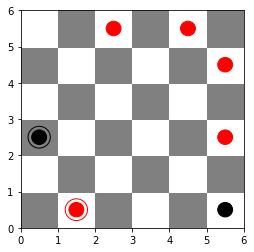

In [34]:
self = game
#plt.clf()
rcParams['figure.figsize'] = 4,4
#fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

#ax.add_artist(circle2)
fig, ax = plt.subplots() 

#ax.add_artist(plt.Circle( (i + .5, j + .5), 0.2, color='blue'))

for i in range(self.board_size):
    for j in range(self.board_size):
        if (i + j) % 2 == 0:
            square_color = 'grey'
        else:
            square_color = 'white'

        ax.add_artist(plt.Rectangle( (i, j), 1,1, color=square_color))
        if self.board[i,j] > 0:
            color = 'red'
        elif self.board[i,j] < 0:
            color = 'black'
        else:
            continue
        #print i,j
        ax.add_artist(plt.Circle( (i + .5, j + .5), 0.2, color=color))
        if abs(self.board[i,j]) > 1:
            ###This piece is a king
            ax.add_artist(plt.Circle( (i + .5, j + .5), 0.3, color=color, fill = False))

plt.xlim(0,self.board_size)
plt.ylim(0,self.board_size)

plt.show()